# Part 1: MNIST classification with Pytorch
The goal of the first part is to learn how to use Pytorch and to observe the impact of regularization during training. You should test different network architectures, e.g. with hidden layers of size 128-128, 128-64-32-16, 256-128-64-32-16, 512-256-128-64-32-16, 800-800, and different activation functions (tanh, relu, sigmoid).

In [83]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn 
import torch.nn.functional as F
import time
import copy

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

## Data preparation

label: 4


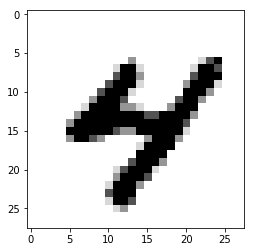

In [84]:
# Download mnist dataset 
if("mnist.pkl.gz" not in os.listdir(".")):
    !wget http://deeplearning.net/data/mnist/mnist.pkl.gz

# if you have it somewhere else, you can comment the lines above
# and overwrite the path below
mnist_path = "./mnist.pkl.gz"


# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)


index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

In [85]:
first = 20
image = torch.from_numpy(train_data[0][first])
print(image.shape) # flat image of dim (784,)

# reshape the tensor so it is represented as a batch containing a single image
# -1 means "all remaining elements", here it would be equivalent to image.reshape(1, 784)
image = image.reshape(1, -1)
print(image.shape) # flat image of dim (1, 784)

torch.Size([784])
torch.Size([1, 784])


In [86]:
# Constructing a batched input
batch_size = 10
first = 20

# the cat() function concatenates a list of tensor along a dimension
batch_input = torch.cat(
    [
        # we reshape the image tensor so it has dimension (1, 784)
        torch.from_numpy(image).reshape(1, -1)
        for image in train_data[0][first:first + batch_size]
    ],
    # we want to concatenate on the batch dimension
    dim=0
)
print(batch_input.shape)  # batch of ten flat images (10, 784)

torch.Size([10, 784])


## Models

### MLP

In [87]:
class MLP(nn.Module):
    def __init__(self, h_sizes, activ_func, p):
        super(MLP, self).__init__()

        self.activ_func = activ_func 
        
        # definition and initialization of hidden layers
        self.hidden = nn.ModuleList()
        for k in range(len(h_sizes)-1):
            self.hidden.append(nn.Linear(h_sizes[k], h_sizes[k+1]))
                
        for hidden in self.hidden:
            nn.init.xavier_uniform_(hidden.weight.data)
            nn.init.zeros_(hidden.bias.data)
            

        # definition and initialization of ouput layer
        self.out = nn.Linear(h_sizes[-1], 10)
        nn.init.xavier_uniform_(self.out.weight.data)  # Xavier/Glorot init for tanh
        nn.init.zeros_(self.out.bias.data)  # Xavier/Glorot init for tanh 
        
        # dropout : if p=0. there is no dropout
        self.dropout = nn.Dropout(p=p)

        
    def forward(self, x):
        
        if self.activ_func == "tanh":
            for hidden in self.hidden:
                x = self.dropout(torch.tanh(hidden(x)))       
        elif self.activ_func == "relu":
            for hidden in self.hidden:
                x = self.dropout(F.relu(hidden(x)))
        elif self.activ_func == "sigmoid":
            for hidden in self.hidden:
                x = self.dropout(torch.sigmoid(hidden(x)))        
            
        return F.softmax(self.out(x), dim=1)

### CNN

In [95]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.is_convolutional = True

        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        
        self.hidden = nn.Linear(800, 500)
        self.out = nn.Linear(500, 10)
        
        nn.init.xavier_uniform_(self.hidden.weight.data)
        nn.init.zeros_(self.hidden.bias.data)
        
        nn.init.zeros_(self.out.bias.data)
        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.hidden(x))
        x = self.out(self.dropout(x))
        
        return F.softmax(x, dim=1)


## Training Loop

In [89]:
# Necessary functions

def get_batches(data):
    return [(data[0][i:i+batch_size], data[1][i:i+batch_size]) for i in range(0, len(data[0]), batch_size)]

def train(model, lr, weight_decay=5e-4, is_convolutional=False, n_epochs=10):
    
    # optimizer definition using weight decay
    optimizer = torch.optim.SGD(params=model.parameters(), lr=lr, weight_decay=weight_decay)
    # loss function
    loss = nn.NLLLoss()
    # activate train mode
    model.train()
    # use checkpoints to avoid overfitting
    checkpoints = []
    
    # variables to see the progression
    train_loss = []
    dev_loss = []
    train_acc = []
    dev_acc = []
    
    start_time = time.time()        
    for i in range(n_epochs): # epochs
        
        t_loss = 0
        t_acc = 0
        d_loss = 0
        d_acc = 0
        
        for x, y in get_batches(train_data):
            
            x = x.reshape(10, 1, 28,28) if is_convolutional else x
            pred = model(torch.from_numpy(x))
            label = torch.LongTensor(y)
            output = loss(pred, label)
            
            t_loss += output.item() 
            t_acc += len([1 for i, j in zip(label, torch.max(pred, dim=1)[1]) if i == j]) 

            
            optimizer.zero_grad()
            output.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
        
        train_loss.append(t_loss/len(train_data[0]))
        train_acc.append(t_acc/len(train_data[0]))
        
        
        for x, y in get_batches(dev_data):
            x = x.reshape(10, 1, 28,28) if is_convolutional else x
            pred = model(torch.from_numpy(x))
            label = torch.LongTensor(y)
            output = loss(pred, label)
            
            d_loss += output.item() 
            d_acc += len([1 for i, j in zip(label, torch.max(pred, dim=1)[1]) if i == j]) 
        
        dev_loss.append(d_loss/len(dev_data[0]))
        dev_acc.append(d_acc/len(dev_data[0]))
        
        checkpoints.append(copy.deepcopy(model.state_dict()))
       
        print("EPOCH" , str(i+1) ,"On the train data : mean loss is : " , np.float(t_loss/len(train_data[0])) , " accuracy is : " ,t_acc/len(train_data[0]))
        print("EPOCH" , str(i+1) ,"On the dev data : mean loss is : " , d_loss/len(dev_data[0]) , " accuracy is : " ,d_acc/len(dev_data[0]))
        print("----------------------------------------------------------------------------")
   
    duration = time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time))
    print("Training finish in ", duration)
        
    
    plt.figure(figsize=(10, 4))
    #Plotting accuracy curves for dev and train data
    plt.subplot(1, 2, 1)
    plt.plot(train_acc , label='Train')
    plt.plot(dev_acc, label="Dev")
    plt.title("Accuracy in terms of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    #Plotting loss curves for dev and train data
    plt.subplot(1, 2, 2)
    plt.plot(train_loss , label='Train')
    plt.plot(dev_loss, label="Dev")
    plt.title("Loss in terms of epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()
    
    return checkpoints

In [90]:
#Calculating accuracy on test data
def test_accuracy(model, is_convolutional= False):
    
    accuracy = 0
    # loss function
    loss = nn.NLLLoss()    
    for x, y in get_batches(test_data):
            
            x = x.reshape(10, 1, 28, 28) if is_convolutional else x
            pred = model(torch.from_numpy(x))
            label = torch.LongTensor(y)
            output = loss(pred, label)
                        
            
            #computing accuracy
            accuracy += len([1 for i, j in zip(label, torch.max(pred, dim=1)[1]) if i == j]) 

            
    #print("Accuracy on test set for this model is " , accuracy/len(test_data[0]))
    return(accuracy/len(test_data[0]))

## Tests

EPOCH 1 On the train data : mean loss is :  -0.06715205877944827  accuracy is :  0.68478
EPOCH 1 On the dev data : mean loss is :  -0.07577323206365108  accuracy is :  0.7639
----------------------------------------------------------------------------
EPOCH 2 On the train data : mean loss is :  -0.07540210448741913  accuracy is :  0.76034
EPOCH 2 On the dev data : mean loss is :  -0.07681239854693413  accuracy is :  0.7742
----------------------------------------------------------------------------
EPOCH 3 On the train data : mean loss is :  -0.07629791992247105  accuracy is :  0.76888
EPOCH 3 On the dev data : mean loss is :  -0.07711710568666458  accuracy is :  0.777
----------------------------------------------------------------------------
EPOCH 4 On the train data : mean loss is :  -0.0767828048223257  accuracy is :  0.77392
EPOCH 4 On the dev data : mean loss is :  -0.07732624753713607  accuracy is :  0.7794
-----------------------------------------------------------------------

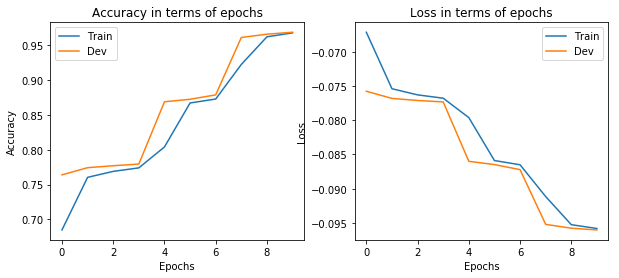

In [91]:
#Model 128-128 with relu, without dropout
Model_1 = MLP([784,128,128], "relu", 0.)
a = train(Model_1, 0.1)

EPOCH 1 On the train data : mean loss is :  -0.07855898498162628  accuracy is :  0.80084
EPOCH 1 On the dev data : mean loss is :  -0.08472319123744965  accuracy is :  0.8553
----------------------------------------------------------------------------
EPOCH 2 On the train data : mean loss is :  -0.08482157229423523  accuracy is :  0.85598
EPOCH 2 On the dev data : mean loss is :  -0.08594784264862537  accuracy is :  0.868
----------------------------------------------------------------------------
EPOCH 3 On the train data : mean loss is :  -0.08595758051991463  accuracy is :  0.86732
EPOCH 3 On the dev data : mean loss is :  -0.08694653641879559  accuracy is :  0.8771
----------------------------------------------------------------------------
EPOCH 4 On the train data : mean loss is :  -0.08658861935853958  accuracy is :  0.87362
EPOCH 4 On the dev data : mean loss is :  -0.08705552498996258  accuracy is :  0.8789
----------------------------------------------------------------------

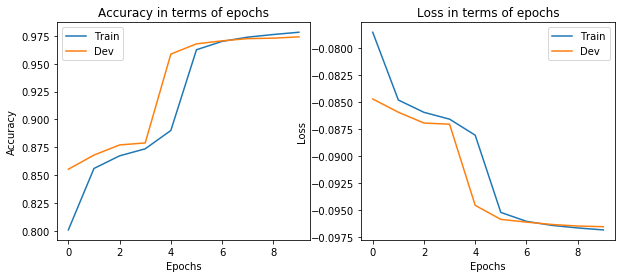

In [92]:
#Model 800-800 with relu, without dropout
Model_2 = MLP([784,800,800], "relu", 0.)
a = train(Model_2, 0.1)

EPOCH 1 On the train data : mean loss is :  -0.06487956980213523  accuracy is :  0.65868
EPOCH 1 On the dev data : mean loss is :  -0.07141734054386616  accuracy is :  0.7184
----------------------------------------------------------------------------
EPOCH 2 On the train data : mean loss is :  -0.07457000134855508  accuracy is :  0.74978
EPOCH 2 On the dev data : mean loss is :  -0.07537776926755906  accuracy is :  0.7582
----------------------------------------------------------------------------
EPOCH 3 On the train data : mean loss is :  -0.07578575696617365  accuracy is :  0.7622
EPOCH 3 On the dev data : mean loss is :  -0.07653867824673653  accuracy is :  0.7694
----------------------------------------------------------------------------
EPOCH 4 On the train data : mean loss is :  -0.08364068679451943  accuracy is :  0.84266
EPOCH 4 On the dev data : mean loss is :  -0.08558221615850925  accuracy is :  0.8606
----------------------------------------------------------------------

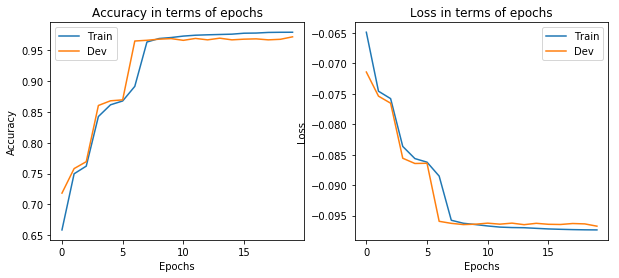

In [93]:
#Model 128-64-32-16 with relu, without dropout
Model_3 = MLP([784,128,64,32,16], "relu", 0.)
a = train(Model_3, 0.1, weight_decay=5e-4, is_convolutional=False, n_epochs= 20)

EPOCH 1 On the train data : mean loss is :  -0.06282069441907108  accuracy is :  0.63782
EPOCH 1 On the dev data : mean loss is :  -0.07617928801625967  accuracy is :  0.7642
----------------------------------------------------------------------------
EPOCH 2 On the train data : mean loss is :  -0.07779770067691803  accuracy is :  0.78186
EPOCH 2 On the dev data : mean loss is :  -0.08851953699588776  accuracy is :  0.893
----------------------------------------------------------------------------
EPOCH 3 On the train data : mean loss is :  -0.09267248265266419  accuracy is :  0.932
EPOCH 3 On the dev data : mean loss is :  -0.09481476200222969  accuracy is :  0.952
----------------------------------------------------------------------------
EPOCH 4 On the train data : mean loss is :  -0.09504682669997215  accuracy is :  0.95524
EPOCH 4 On the dev data : mean loss is :  -0.09610413547158242  accuracy is :  0.9643
-------------------------------------------------------------------------

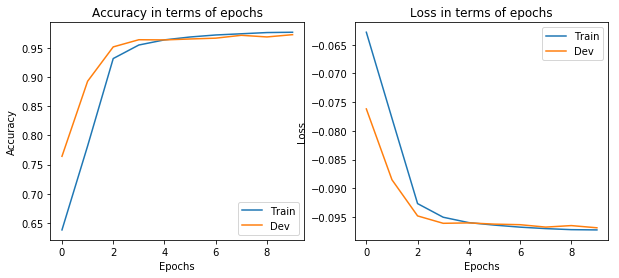

In [27]:
#Model 512-256-128-64-32-16 with relu, without dropout
Model_4 = MLP([784,512,256,128,64,32,16], "relu", 0.)
a = train(Model_4, 0.1)

EPOCH 1 On the train data : mean loss is :  -0.07598792247459292  accuracy is :  0.78298
EPOCH 1 On the dev data : mean loss is :  -0.08897511082291604  accuracy is :  0.9031
----------------------------------------------------------------------------
EPOCH 2 On the train data : mean loss is :  -0.09016306123554707  accuracy is :  0.91446
EPOCH 2 On the dev data : mean loss is :  -0.09264805886745453  accuracy is :  0.9371
----------------------------------------------------------------------------
EPOCH 3 On the train data : mean loss is :  -0.092158426040411  accuracy is :  0.93278
EPOCH 3 On the dev data : mean loss is :  -0.09367638787627221  accuracy is :  0.9476
----------------------------------------------------------------------------
EPOCH 4 On the train data : mean loss is :  -0.09323759299993516  accuracy is :  0.9434
EPOCH 4 On the dev data : mean loss is :  -0.09431815713644028  accuracy is :  0.9519
------------------------------------------------------------------------

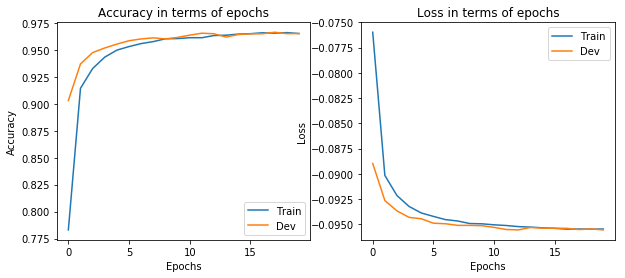

In [57]:
#Model 800-800 with relu, with dropout p=0.5
Model_5 = MLP([784,800,800], "relu", 0.5)
a = train(Model_5, 0.1, 5e-4, False, 20)

EPOCH 1 On the train data : mean loss is :  -0.07062569643482566  accuracy is :  0.72884
EPOCH 1 On the dev data : mean loss is :  -0.08103994732201099  accuracy is :  0.8199
----------------------------------------------------------------------------
EPOCH 2 On the train data : mean loss is :  -0.08316892735123635  accuracy is :  0.84558
EPOCH 2 On the dev data : mean loss is :  -0.08811827852129936  accuracy is :  0.8953
----------------------------------------------------------------------------
EPOCH 3 On the train data : mean loss is :  -0.08788306392490863  accuracy is :  0.8916
EPOCH 3 On the dev data : mean loss is :  -0.08991598707437515  accuracy is :  0.9116
----------------------------------------------------------------------------
EPOCH 4 On the train data : mean loss is :  -0.08923713404357433  accuracy is :  0.90462
EPOCH 4 On the dev data : mean loss is :  -0.09022267881035805  accuracy is :  0.914
-----------------------------------------------------------------------

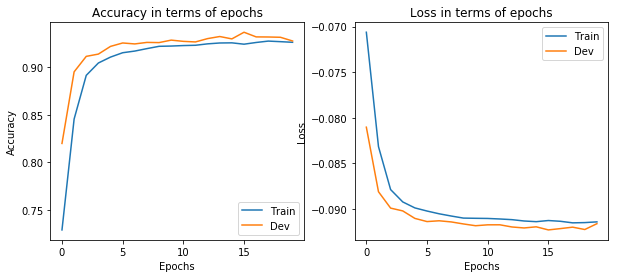

In [52]:
#Model 128-128 with relu, with dropout p=0.5
Model_6 = MLP([784,128,128], "relu", 0.5)
a = train(Model_6, 0.1, 5e-4, False, 20)

EPOCH 1 On the train data : mean loss is :  -0.07973327301308512  accuracy is :  0.82844
EPOCH 1 On the dev data : mean loss is :  -0.08807803133130074  accuracy is :  0.8948
----------------------------------------------------------------------------
EPOCH 2 On the train data : mean loss is :  -0.08740003631591797  accuracy is :  0.8883
EPOCH 2 On the dev data : mean loss is :  -0.08907322472929954  accuracy is :  0.9009
----------------------------------------------------------------------------
EPOCH 3 On the train data : mean loss is :  -0.08826480575621128  accuracy is :  0.89446
EPOCH 3 On the dev data : mean loss is :  -0.08989971811175346  accuracy is :  0.9074
----------------------------------------------------------------------------
EPOCH 4 On the train data : mean loss is :  -0.0888150624203682  accuracy is :  0.89964
EPOCH 4 On the dev data : mean loss is :  -0.09024298612475395  accuracy is :  0.9144
-----------------------------------------------------------------------

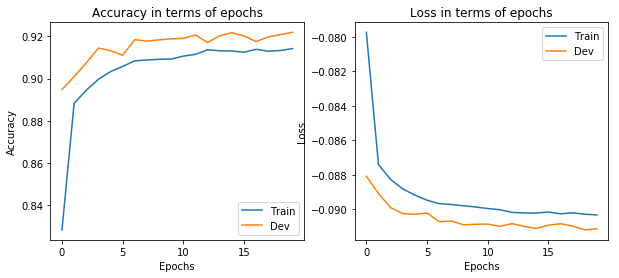

In [53]:
#Model 128-128 with tanh, with dropout p=0.5
Model_7 = MLP([784,128,128], "tanh", 0.5)
a = train(Model_7, 0.1, 5e-4, False, 20)

EPOCH 1 On the train data : mean loss is :  -0.08587639796823263  accuracy is :  0.88396
EPOCH 1 On the dev data : mean loss is :  -0.09204730159044265  accuracy is :  0.933
----------------------------------------------------------------------------
EPOCH 2 On the train data : mean loss is :  -0.09203465301096439  accuracy is :  0.93248
EPOCH 2 On the dev data : mean loss is :  -0.09341290311813355  accuracy is :  0.9462
----------------------------------------------------------------------------
EPOCH 3 On the train data : mean loss is :  -0.0933120156776905  accuracy is :  0.94458
EPOCH 3 On the dev data : mean loss is :  -0.09407543352246285  accuracy is :  0.9517
----------------------------------------------------------------------------
EPOCH 4 On the train data : mean loss is :  -0.09408664400935172  accuracy is :  0.95224
EPOCH 4 On the dev data : mean loss is :  -0.09461595460176468  accuracy is :  0.956
------------------------------------------------------------------------

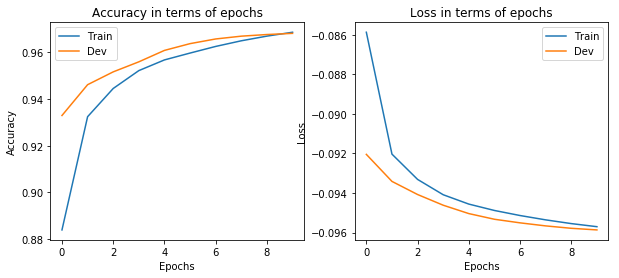

In [37]:
#Model 128-128 with relu, with dropout p=0.5
Model_8 = MLP([784,128,128], "tanh", 0.)
a = train(Model_8, 0.1)

EPOCH 1 On the train data : mean loss is :  -0.0776900508850813  accuracy is :  0.78906
EPOCH 1 On the dev data : mean loss is :  -0.08597362584471703  accuracy is :  0.8635
----------------------------------------------------------------------------
EPOCH 2 On the train data : mean loss is :  -0.08879965050041676  accuracy is :  0.8924
EPOCH 2 On the dev data : mean loss is :  -0.09581951942443848  accuracy is :  0.9639
----------------------------------------------------------------------------
EPOCH 3 On the train data : mean loss is :  -0.09606808921813965  accuracy is :  0.9642
EPOCH 3 On the dev data : mean loss is :  -0.0966029929459095  accuracy is :  0.9699
----------------------------------------------------------------------------
EPOCH 4 On the train data : mean loss is :  -0.09674913408637047  accuracy is :  0.97096
EPOCH 4 On the dev data : mean loss is :  -0.09707379667162895  accuracy is :  0.9741
-------------------------------------------------------------------------

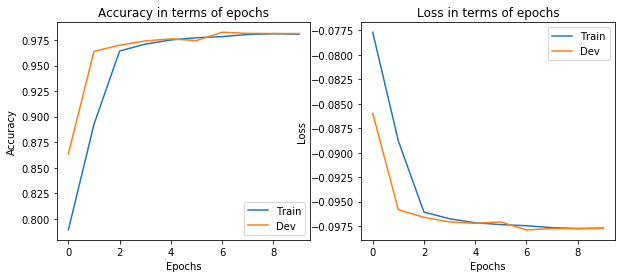

In [51]:
#Model 128-128 with relu, with dropout p=0.5
Model_9 = CNN()
a =train(Model_9, 0.1, 5e-4, True)

In [ ]:
#Model 128-64-32-16 with relu, without dropout
Model_10 = MLP([784,128,64,32,16], "relu", 0.3)
a = train(Model_10, 0.1, weight_decay=5e-4, is_convolutional=False, n_epochs= 20)

In [111]:
# we fix the epoch at 10 and we see the accuracy obtained for each model
best_epochs = [10, 10, 10, 10, 10, 10, 10]
models = [
    [Model_1, "128-128 ", False],
    [Model_2, "800-800 ", False],
    [Model_3, "256-128-64-32-16 ", False],
    [Model_4, "512-256-128-64-32-16", False],
    [Model_5, "800-800 + dropout", False],
    [Model_8,  "128-128 + tanh", False],
    [Model_9,  "CNN", True]
    
]
acc = []
for i, best_epoch in enumerate(best_epochs):
    acc.append(test_accuracy(models[i][0], models[i][2]))
    print("Model ", models[i][1], " : Accuracy = ", test_accuracy(models[i][0], models[i][2]))

Model  128-128   : Accuracy =  0.9662
Model  800-800   : Accuracy =  0.9734
Model  256-128-64-32-16   : Accuracy =  0.969
Model  512-256-128-64-32-16  : Accuracy =  0.9693
Model  800-800 + dropout  : Accuracy =  0.9624
Model  128-128 + tanh  : Accuracy =  0.9663
Model  CNN  : Accuracy =  0.9807


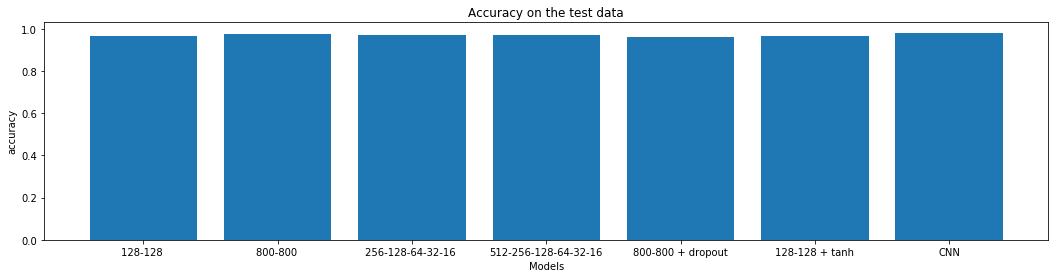

In [112]:
# plot
plt.figure(figsize=(18, 4))
plt.bar([models[model][1] for model in range(len(models))], acc)
plt.xlabel("Models")
plt.ylabel("accuracy")
plt.title("Accuracy on the test data")
plt.show()